In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import skew
import missingno as msno

In [5]:
df=pd.read_csv('/content/cities_by_hours.csv',parse_dates=['Datetime'])
df

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,C6H6,C7H8,C8H10,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [6]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,C6H6,C7H8,C8H10,AQI
count,562787.000000,411138.000000,591243.000000,590753.000000,584651.000000,435333.000000,621358.000000,577502.000000,578667.000000,544229.000000,487268.000000,252046.000000,578795.000000
mean,67.622994,119.075804,17.421755,28.885157,32.287565,23.607959,2.183539,14.038307,34.798979,3.087595,8.660927,3.130537,166.413500
std,74.730496,104.224752,32.095211,29.162194,39.756669,28.831900,10.970514,19.305540,29.806379,16.456599,21.741023,7.834832,162.112729
min,0.010000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,8.000000
25%,26.200000,52.380000,3.840000,10.810000,10.660000,8.120000,0.420000,4.880000,13.420000,0.050000,0.370000,0.100000,79.000000
50%,46.420000,91.500000,7.960000,20.320000,20.790000,15.380000,0.800000,8.370000,26.240000,0.860000,2.590000,0.790000,116.000000
75%,79.490000,147.520000,16.150000,36.350000,37.150000,29.230000,1.370000,14.780000,47.620000,2.750000,8.410000,3.120000,208.000000
max,999.990000,1000.000000,499.990000,499.510000,498.610000,499.970000,498.570000,199.960000,497.620000,498.070000,499.400000,499.990000,3133.000000


In [7]:
missing_values=pd.DataFrame(df.isna().sum()/len(df))
missing_values.columns=['Proportion']
missing_values=missing_values.sort_values(by='Proportion',ascending=False)
missing_values.style.background_gradient(cmap='Blues')

,Proportion
C8H10,0.643940
PM10,0.419194
NH3,0.385014
C7H8,0.311647
C6H6,0.231179
PM2.5,0.204963
SO2,0.184175
O3,0.182529
AQI,0.182349
AQI_Bucket,0.182349


In [8]:
df.columns

Index(['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'C6H6', 'C7H8', 'C8H10', 'AQI', 'AQI_Bucket'],
      dtype='object')

In [9]:
df.shape

(707875, 16)

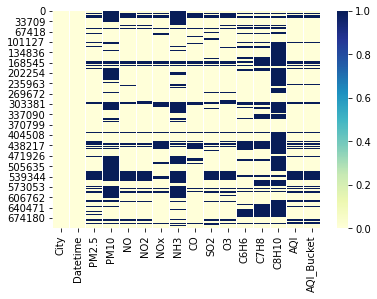

In [10]:
sns.heatmap(df.isnull(),cmap="YlGnBu")

In [11]:
df.iloc[:,1:14]=df.groupby("City").transform(lambda x:x.fillna(x.mean()))

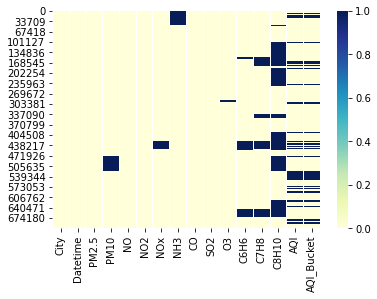

In [12]:
sns.heatmap(df.isnull(),cmap="YlGnBu")

In [13]:
df.isnull().sum()

City               0
Datetime           0
PM2.5              0
PM10           48192
NO                 0
NO2                0
NOx            28025
NH3            48192
CO                 0
SO2                0
O3              3852
C6H6           65433
C7H8           96049
C8H10         312656
AQI           129080
AQI_Bucket    129080
dtype: int64

In [14]:
df['PM10']=df['PM10'].fillna((df['PM10'].mean()))
df['NOx']=df['NOx'].fillna((df['NOx'].mean()))
df['NH3']=df['NH3'].fillna((df['NH3'].mean()))
df['O3']=df['O3'].fillna((df['O3'].mean()))
df['C6H6']=df['C6H6'].fillna((df['C6H6'].mean()))
df['C7H8']=df['C7H8'].fillna((df['C7H8'].mean()))
df['C8H10']=df['C8H10'].fillna((df['C8H10'].mean()))

In [15]:
missing_values=pd.DataFrame(df.isnull().sum())
missing_values.style.background_gradient(cmap="Blues")

,0
City,0
Datetime,0
PM2.5,0
PM10,0
NO,0
NO2,0
NOx,0
NH3,0
CO,0
SO2,0


In [16]:
def aqi_calc(df):
    df["PM10_24hr_avg"] = df.groupby("City")["PM10"].rolling(window = 24, min_periods = 16).mean().values
    df["PM2.5_24hr_avg"] = df.groupby("City")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
    df["SO2_24hr_avg"] = df.groupby("City")["SO2"].rolling(window = 24, min_periods = 16).mean().values
    df["NOx_24hr_avg"] = df.groupby("City")["NOx"].rolling(window = 24, min_periods = 16).mean().values
    df["NH3_24hr_avg"] = df.groupby("City")["NH3"].rolling(window = 24, min_periods = 16).mean().values
    df["CO_8hr_max"] = df.groupby("City")["CO"].rolling(window = 8, min_periods = 1).max().values
    df["O3_8hr_max"] = df.groupby("City")["O3"].rolling(window = 8, min_periods = 1).max().values

In [17]:
aqi_calc(df)

In [18]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
        if x <= 30:
            return x * 50 / 30
        elif x <= 60:
            return 50 + (x - 30) * 50 / 30
        elif x <= 90:
            return 100 + (x - 60) * 100 / 30
        elif x <= 120:
            return 200 + (x - 90) * 100 / 30
        elif x <= 250:
            return 300 + (x - 120) * 100 / 130
        elif x > 250:
            return 400 + (x - 250) * 100 / 130
        else:
            return 0


df["PM2.5_SubIndex"] = df["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))

    ## PM10 Sub-Index calculation
def get_PM10_subindex(x):
        if x <= 50:
            return x
        elif x <= 100:
            return x
        elif x <= 250:
            return 100 + (x - 100) * 100 / 150
        elif x <= 350:
            return 200 + (x - 250)
        elif x <= 430:
            return 300 + (x - 350) * 100 / 80
        elif x > 430:
            return 400 + (x - 430) * 100 / 80
        else:
            return 0

df["PM10_SubIndex"] = df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))



    ## SO2 Sub-Index calculation
def get_SO2_subindex(x):
        if x <= 40:
            return x * 50 / 40
        elif x <= 80:
            return 50 + (x - 40) * 50 / 40
        elif x <= 380:
            return 100 + (x - 80) * 100 / 300
        elif x <= 800:
            return 200 + (x - 380) * 100 / 420
        elif x <= 1600:
            return 300 + (x - 800) * 100 / 800
        elif x > 1600:
            return 400 + (x - 1600) * 100 / 800
        else:
            return 0

df["SO2_SubIndex"] = df["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))
    ## NOx Sub-Index calculation
def get_NOx_subindex(x):
        if x <= 40:
            return x * 50 / 40
        elif x <= 80:
            return 50 + (x - 40) * 50 / 40
        elif x <= 180:
            return 100 + (x - 80) * 100 / 100
        elif x <= 280:
            return 200 + (x - 180) * 100 / 100
        elif x <= 400:
            return 300 + (x - 280) * 100 / 120
        elif x > 400:
            return 400 + (x - 400) * 100 / 120
        else:
            return 0

df["NOx_SubIndex"] = df["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))

    ## NH3 Sub-Index calculation
def get_NH3_subindex(x):
        if x <= 200:
            return x * 50 / 200
        elif x <= 400:
            return 50 + (x - 200) * 50 / 200
        elif x <= 800:
            return 100 + (x - 400) * 100 / 400
        elif x <= 1200:
            return 200 + (x - 800) * 100 / 400
        elif x <= 1800:
            return 300 + (x - 1200) * 100 / 600
        elif x > 1800:
            return 400 + (x - 1800) * 100 / 600
        else:
            return 0

df["NH3_SubIndex"] = df["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))

    ## CO Sub-Index calculation
def get_CO_subindex(x):
        if x <= 1:
            return x * 50 / 1
        elif x <= 2:
            return 50 + (x - 1) * 50 / 1
        elif x <= 10:
            return 100 + (x - 2) * 100 / 8
        elif x <= 17:
            return 200 + (x - 10) * 100 / 7
        elif x <= 34:
            return 300 + (x - 17) * 100 / 17
        elif x > 34:
            return 400 + (x - 34) * 100 / 17
        else:
            return 0

df["CO_SubIndex"] = df["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

    ## O3 Sub-Index calculation
def get_O3_subindex(x):
        if x <= 50:
            return x * 50 / 50
        elif x <= 100:
            return 50 + (x - 50) * 50 / 50
        elif x <= 168:
            return 100 + (x - 100) * 100 / 68
        elif x <= 208:
            return 200 + (x - 168) * 100 / 40
        elif x <= 748:
            return 300 + (x - 208) * 100 / 539
        elif x > 748:
            return 400 + (x - 400) * 100 / 539
        else:
            return 0

df["O3_SubIndex"] = df["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))
    ## AQI bucketing
def get_AQI_bucket(x):
        if x <= 50:
            return "Good"
        elif x <= 100:
            return "Satisfactory"
        elif x <= 200:
          return "Moderate"
        elif x <= 300:
            return "Poor"
        elif x <= 400:
            return "Very Poor"
        elif x > 400:
            return "Severe"
        else:
            return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                    (df["PM10_SubIndex"] > 0).astype(int) + \
                    (df["SO2_SubIndex"] > 0).astype(int) + \
                    (df["NOx_SubIndex"] > 0).astype(int) + \
                    (df["NH3_SubIndex"] > 0).astype(int) + \
                    (df["CO_SubIndex"] > 0).astype(int) + \
                    (df["O3_SubIndex"] > 0).astype(int)

df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                     "NH3_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))

In [19]:
df

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,C6H6,C7H8,C8H10,AQI,AQI_Bucket,PM10_24hr_avg,PM2.5_24hr_avg,SO2_24hr_avg,NOx_24hr_avg,NH3_24hr_avg,CO_8hr_max,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,Ahmedabad,2015-01-01 01:00:00,67.273271,111.493008,1.00,40.01,36.37,23.012932,1.00,122.070000,39.067821,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,39.067821,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,39.067821,2,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,67.273271,111.493008,0.02,27.75,19.73,23.012932,0.02,85.900000,39.067821,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,39.067821,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,39.067821,2,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,67.273271,111.493008,0.08,19.32,11.08,23.012932,0.08,52.830000,39.067821,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,39.067821,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,39.067821,2,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,67.273271,111.493008,0.30,16.45,9.20,23.012932,0.30,39.530000,153.580000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,153.580000,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,178.794118,2,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,67.273271,111.493008,0.12,14.90,7.85,23.012932,0.12,32.630000,39.067821,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,153.580000,0.000000,0.000000,0.000000,0.000000,0.000000,50.0,178.794118,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.500000,36.000000,2.75,25.57,15.85,4.570000,0.62,12.750689,27.750000,3.842899,8.179757,2.725523,51.0,Satisfactory,48.000000,16.156250,10.231307,17.695833,10.135000,0.66,50.730000,26.927083,48.000000,12.789134,22.119792,2.533750,33.0,50.730000,7,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.250000,49.250000,3.62,33.20,20.62,3.780000,0.76,2.020000,25.580000,3.842899,8.179757,2.725523,51.0,Satisfactory,48.447917,16.218750,10.085057,18.109167,10.036250,0.76,50.730000,27.031250,48.447917,12.606322,22.636458,2.509062,38.0,50.730000,7,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.000000,71.000000,2.20,30.80,18.20,3.670000,0.58,1.770000,26.150000,3.842899,8.179757,2.725523,50.0,Good,49.770833,16.895833,10.069224,18.496667,10.007917,0.76,41.550000,28.159722,49.770833,12.586530,23.120833,2.501979,38.0,41.550000,7,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.750000,63.000000,1.02,28.90,16.00,3.800000,0.49,0.750000,15.820000,3.842899,8.179757,2.725523,50.0,Good,49.968750,16.635417,10.081724,18.799583,10.031667,0.76,41.380000,27.725694,49.968750,12.602155,23.499479,2.507917,38.0,41.380000,7,50.0,Good


In [20]:
df.shape

(707875, 33)

In [21]:
df.drop(['AQI','AQI_Bucket'],axis=1,inplace=True)

In [22]:
df.dropna(inplace=True,axis=0)

In [23]:
df.shape

(707485, 31)

In [24]:
df.columns

Index(['City', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO',
       'SO2', 'O3', 'C6H6', 'C7H8', 'C8H10', 'PM10_24hr_avg', 'PM2.5_24hr_avg',
       'SO2_24hr_avg', 'NOx_24hr_avg', 'NH3_24hr_avg', 'CO_8hr_max',
       'O3_8hr_max', 'PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex',
       'NOx_SubIndex', 'NH3_SubIndex', 'CO_SubIndex', 'O3_SubIndex', 'Checks',
       'AQI_calculated', 'AQI_bucket_calculated'],
      dtype='object')

In [25]:
df

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,C6H6,C7H8,C8H10,PM10_24hr_avg,PM2.5_24hr_avg,SO2_24hr_avg,NOx_24hr_avg,NH3_24hr_avg,CO_8hr_max,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
15,Ahmedabad,2015-01-01 16:00:00,67.273271,111.493008,0.87,17.28,18.32,23.012932,0.87,17.830000,39.067821,0.000000,0.000000,0.000000,111.493008,67.273271,33.943750,16.070625,23.012932,2.27,122.08,124.244236,107.662005,42.429688,20.088281,5.753233,103.375,132.470588,7,132.0,Moderate
16,Ahmedabad,2015-01-01 17:00:00,67.273271,111.493008,0.80,19.04,20.00,23.012932,0.80,16.140000,187.620000,0.000000,0.000000,0.000000,111.493008,67.273271,32.896471,16.301765,23.012932,2.27,187.62,124.244236,107.662005,41.120588,20.377206,5.753233,103.375,249.050000,7,249.0,Poor
17,Ahmedabad,2015-01-01 18:00:00,67.273271,111.493008,0.47,21.24,22.70,23.012932,0.47,11.930000,39.067821,0.000000,0.000000,0.000000,111.493008,67.273271,31.731667,16.657222,23.012932,2.27,187.62,124.244236,107.662005,39.664583,20.821528,5.753233,103.375,249.050000,7,249.0,Poor
18,Ahmedabad,2015-01-01 19:00:00,67.273271,111.493008,0.53,25.63,27.42,23.012932,0.53,14.990000,39.067821,0.000000,0.330000,0.000000,111.493008,67.273271,30.850526,17.223684,23.012932,1.85,187.62,124.244236,107.662005,38.563158,21.529605,5.753233,92.500,249.050000,7,249.0,Poor
19,Ahmedabad,2015-01-01 20:00:00,67.273271,111.493008,0.47,16.22,16.00,23.012932,0.47,13.660000,187.420000,0.000000,0.230000,0.000000,111.493008,67.273271,29.991000,17.162500,23.012932,1.85,187.62,124.244236,107.662005,37.488750,21.453125,5.753233,92.500,249.050000,7,249.0,Poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.500000,36.000000,2.75,25.57,15.85,4.570000,0.62,12.750689,27.750000,3.842899,8.179757,2.725523,48.000000,16.156250,10.231307,17.695833,10.135000,0.66,50.73,26.927083,48.000000,12.789134,22.119792,2.533750,33.000,50.730000,7,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.250000,49.250000,3.62,33.20,20.62,3.780000,0.76,2.020000,25.580000,3.842899,8.179757,2.725523,48.447917,16.218750,10.085057,18.109167,10.036250,0.76,50.73,27.031250,48.447917,12.606322,22.636458,2.509062,38.000,50.730000,7,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.000000,71.000000,2.20,30.80,18.20,3.670000,0.58,1.770000,26.150000,3.842899,8.179757,2.725523,49.770833,16.895833,10.069224,18.496667,10.007917,0.76,41.55,28.159722,49.770833,12.586530,23.120833,2.501979,38.000,41.550000,7,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.750000,63.000000,1.02,28.90,16.00,3.800000,0.49,0.750000,15.820000,3.842899,8.179757,2.725523,49.968750,16.635417,10.081724,18.799583,10.031667,0.76,41.38,27.725694,49.968750,12.602155,23.499479,2.507917,38.000,41.380000,7,50.0,Good


Text(0.5, 1.0, 'Correlation Analysis')

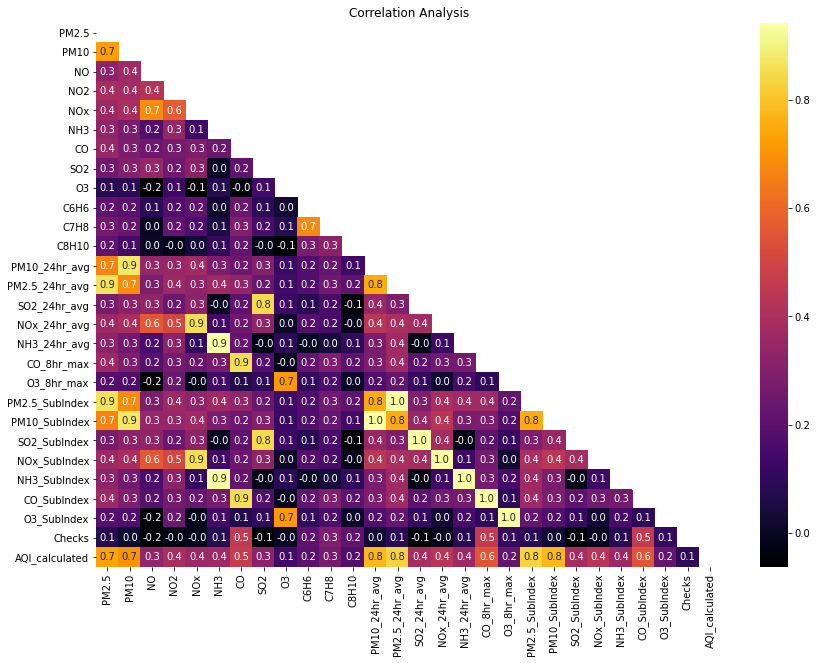

In [26]:
#Correlation analysis
plt.figure(figsize=(14,10))

mask=np.triu(df.corr(method='spearman'))
sns.heatmap(df.corr(method='spearman'),
            annot=True,fmt='0.1f',
            mask=mask,
            robust=True,
            cmap='inferno')
plt.title('Correlation Analysis')

In [27]:
df['City'][df['AQI_calculated']>=500].value_counts()


Ahmedabad     8129
Delhi         1088
Gurugram       643
Patna          491
Lucknow        393
Hyderabad      155
Amritsar       121
Jorapokhar     107
Talcher         97
Guwahati        62
Jaipur          22
Name: City, dtype: int64

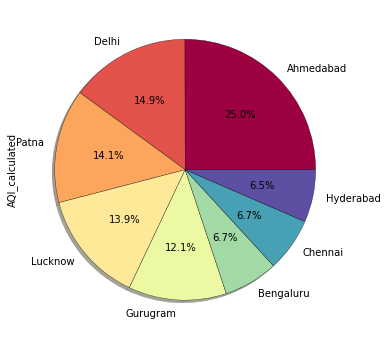

In [29]:
#piechart for the top cities with higher vakues of AQI
cols=['AQI_calculated']

cmap=plt.get_cmap('Spectral')
color=[cmap(i) for i in np.linspace(0,1,8)]

for col in cols:
    plt.figure(figsize=(8,6))   
    x=df.groupby('City')[col].sum().sort_values(ascending=False)
    x.reset_index('City')
    x[:8].plot.pie(shadow=True,autopct='%1.1f%%', colors=color, wedgeprops={'edgecolor':'black','linewidth':0.3})